# Na analysis (run 3898)

# Notebook configuration

In [1]:
outputfolder  = "plots/"
save_plots    = False
inputfilename = ["/Users/Gonzalo/github/NEXTdata/Na22/dst_3890.root.h5",
                 "/Users/Gonzalo/github/NEXTdata/Na22/dst_3896.root.h5",
                 "/Users/Gonzalo/github/NEXTdata/Na22/dst_3898.root.h5",
                 "/Users/Gonzalo/github/NEXTdata/Na22/dst_3901.root.h5"]

In [2]:
from __future__ import print_function, division

import os
import functools
import textwrap
import time
import glob
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt
import scipy             as scp
import scipy.interpolate

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf

pi = np.pi

coref = fitf

Running on  Sat May  6 19:06:23 2017


#### General plotting options

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "-r"
XR1Opt  = "-k"
XR2Opt  = "-c"

if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

In [4]:
def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)


def doublehist(data1, data2, lbls, *args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    h1 = plt.hist(data1, *args, label=lbls[0], alpha=0.5, normed=True, **kwargs)
    h2 = plt.hist(data2, *args, label=lbls[1], alpha=0.5, normed=True, **kwargs)
    return h1, h2, plt.legend()

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def profile_and_scatter(x, y, z, nbin, xrange, yrange, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, xrange, yrange)
    x_ = np.repeat(x, y.size)
    y_ = np.tile  (y, x.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.hist2d(x_, y_, nbin, (xrange, yrange), weights=z_), plt.colorbar()


def doublescatter(x1, y1, x2, y2, lbls, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    sc1 = plt.scatter(x1, y1, *args, label=lbls[0], **kwargs)
    sc2 = plt.scatter(x2, y2, *args, label=lbls[1], **kwargs)
    return sc1, sc2, plt.legend()


def covariance(x, y):
    cov = np.cov(x, y)
    l, v = np.linalg.eig(cov)
    lx, ly = l**0.5
    vx, vy = v.T
    x0, y0 = np.mean(x), np.mean(y)
    x1     = lx * vx[0]
    y1     = lx * vx[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*ly, head_length=0.1*lx, fc='r', ec='r')
    x1     = ly * vy[0]
    y1     = ly * vy[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*lx, head_length=0.1*ly, fc='r', ec='r')
    return l, v

def reso(values, ene=29.6):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (ene/2458)**0.5

def gausstext(values, ene=29.6):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:], *reso(values, ene)))

def save_to_folder(save_plots, outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    if save_plots:
        plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr

def get_tcorr(ts, es, t0 = 0, eref=None):
    if eref is None:
        eref = np.max(es)
    ts   = ts.reshape(ts.size, 1) + t0
    print(eref)
    def tcorr(t):
        t_closest = np.apply_along_axis(np.argmin, 0, abs(t-ts))
        e = es[t_closest]
        return eref/ e
    return tcorr


save = functools.partial(save_to_folder, save_plots, outputfolder)

### Input data

In [5]:
ifile = os.path.expandvars(inputfilename)
print("ifile:", ifile)

ifile: ['/Users/Gonzalo/github/NEXTdata/Na22/dst_3890.root.h5', '/Users/Gonzalo/github/NEXTdata/Na22/dst_3896.root.h5', '/Users/Gonzalo/github/NEXTdata/Na22/dst_3898.root.h5', '/Users/Gonzalo/github/NEXTdata/Na22/dst_3901.root.h5']


# Read data

In [6]:
full = dstf.load_dsts(ifile, "DST", "Events")
full.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.493930e+09,0,1,150.0,17.186361,82.790198,200125.0,11.850000,11215.406250,...,364212.5,27,164.0875,164.0875,-154.552827,-7.315905,154.725882,-3.094292,12.150672,10.149312
1,3,1.493930e+09,0,1,175.0,20.864086,108.257117,200100.0,29.779375,7950.930176,...,449187.5,23,249.0875,249.0875,-172.369086,7.207472,172.519707,3.099803,9.631030,10.483277
2,4,1.493930e+09,0,1,100.0,10.205490,44.000139,200325.0,10.538125,5103.681152,...,508637.5,15,308.3125,308.3125,-139.369313,103.302074,173.479462,2.503740,8.737511,9.255604
3,5,1.493930e+09,0,2,200.0,24.269159,141.606825,200175.0,7.778656,3004.696045,...,383487.5,6,183.3125,183.3125,-162.628310,-30.092320,165.388981,-2.958625,7.242597,5.005801
4,5,1.493930e+09,1,2,200.0,24.269159,141.606825,200175.0,17.318125,13494.689453,...,404437.5,33,204.2625,204.2625,-75.829117,-50.554163,91.136043,-2.553577,12.821304,10.441916


## General plots

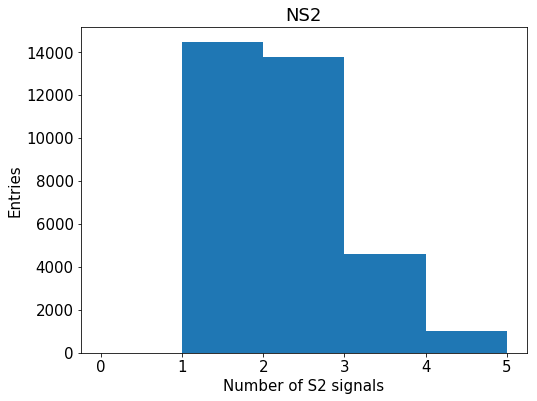

In [7]:
hist(full.nS2, 5, (0,5))
labels("Number of S2 signals", "Entries")
save("NS2")

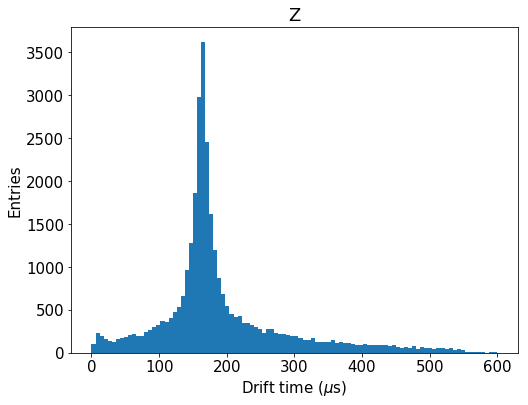

In [8]:
hist(full.Z, 100, (0,600))
labels("Drift time ($\mu$s)", "Entries")
save("Z")

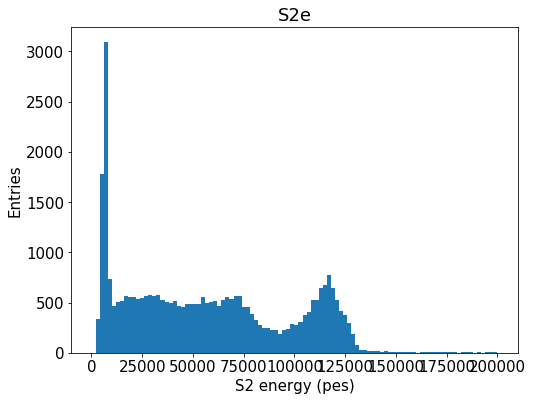

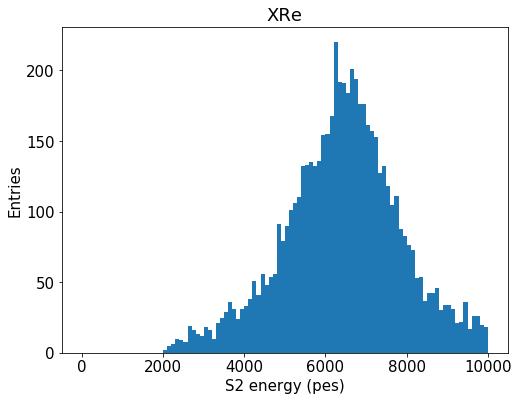

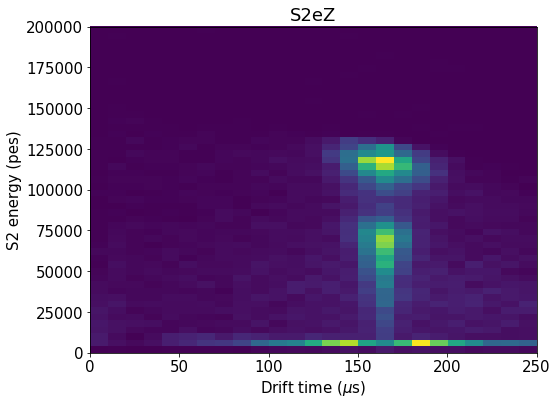

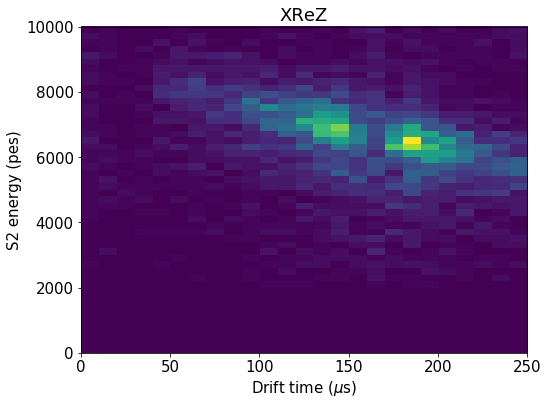

In [9]:
zrange  = 0, 250
Erange  = 0, 2e5
XRrange = 0, 1e4 

hist(full.S2e, 100, Erange)
labels("S2 energy (pes)", "Entries")
save("S2e")

hist(full.S2e, 100, XRrange)
labels("S2 energy (pes)", "Entries")
save("XRe")


hist2d(full.Z, full.S2e, (25, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2eZ")

hist2d(full.Z, full.S2e, (25, 50), range=(zrange, XRrange))
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("XReZ")

# Compute lifetime from XR

In [10]:
zfid = full[ coref.in_range(full.Z  ,   0, 250)]
XR   = zfid[ coref.in_range(zfid.S2e, 4e3, 1e4)]
XR   = XR  [~coref.in_range(  XR.Z  , 160, 175)]

zrange_  =  50, 250
XRrange_ = 2e3, 1e4

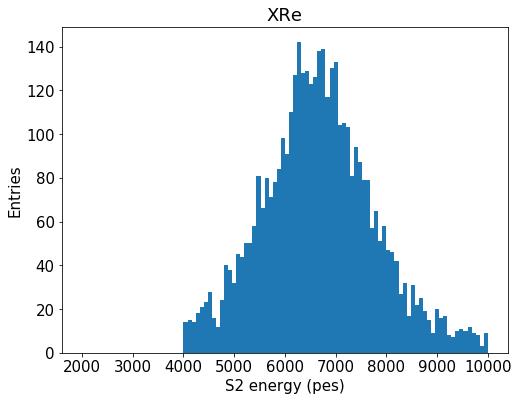

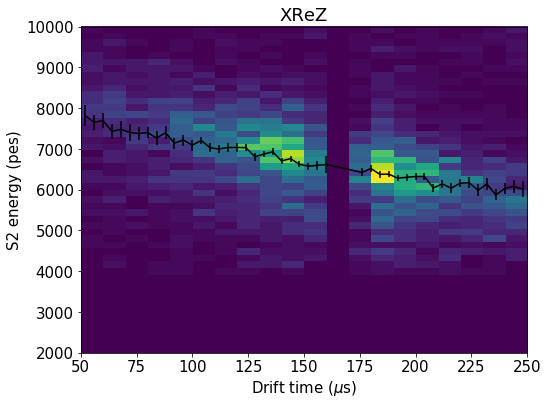

In [11]:
zrange  = zrange_
XRrange = XRrange_

hist(XR.S2e, 100, XRrange)
labels("S2 energy (pes)", "Entries")
save("XRe")

hist2d(XR.Z, XR.S2e, (20, 50), range=(zrange, XRrange))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

x, y, ye = fitf.profileX(XR.Z, XR.S2e, 50, zrange)
plt.errorbar(x, y, ye, fmt="-k")
save("XReZ")

[ 9026.33573826  -611.17996396] 2.03651971047


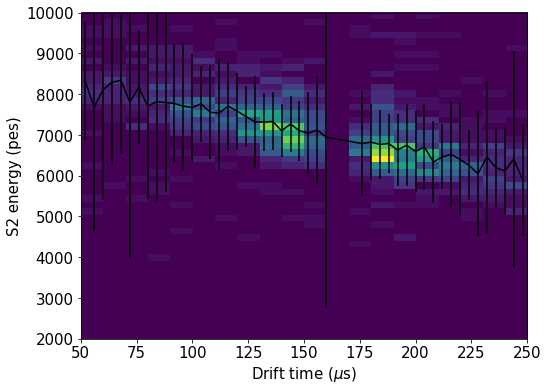

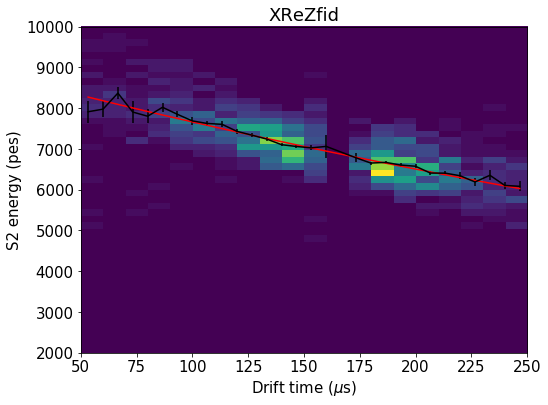

In [12]:
zrange = zrange_
Erange = XRrange_

XRfid = XR[coref.in_range(XR.R, 0, 100)]

hist2d(XRfid.Z, XRfid.S2e, (20, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

x, y, ye = fitf.profileX(XRfid.Z, XRfid.S2e, 50, zrange)
plt.errorbar(x, y, ye*10, fmt="-k")

xr_emin = scp.interpolate.interp1d(x, y - ye*10, fill_value="extrapolate")
xr_emax = scp.interpolate.interp1d(x, y + ye*10, fill_value="extrapolate")

XRfid = XRfid[coref.in_range(XRfid.S2e, xr_emin(XRfid.Z), xr_emax(XRfid.Z))]
hist2d(XRfid.Z, XRfid.S2e, (20, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

x, y, ye = fitf.profileX(XRfid.Z, XRfid.S2e, 30, zrange)
ye[ye == 0] = 3e3
plt.errorbar(x, y, ye, fmt="-k")


f = fitf.fit(fitf.expo, x, y, (8e3, -4e2), sigma=2*ye)
plt.plot(x, f.fn(x), fitOpt)
save("XReZfid")
print(f.values, f.chi2)

zfun  = f.fn
znorm = zfun(zrange[0])
zcorr = lambda z: znorm/zfun(z)

# S2 energy corrected by attachment

[  2.55412390e+05   8.24516763e+03   5.11776723e+02  -2.53566122e+01] 0.50763315326 (14.586426282584529, 1.600677416888566)
[ 494073.21573247    8035.55951126     619.29141356] 0.713674693526 (18.111182174935955, 1.987475186789758)


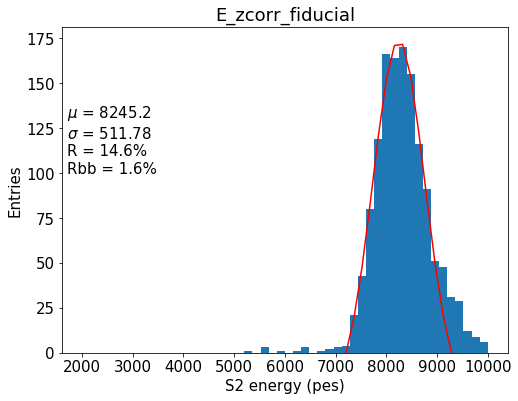

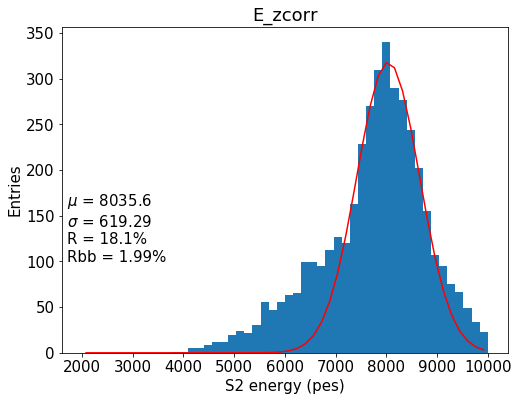

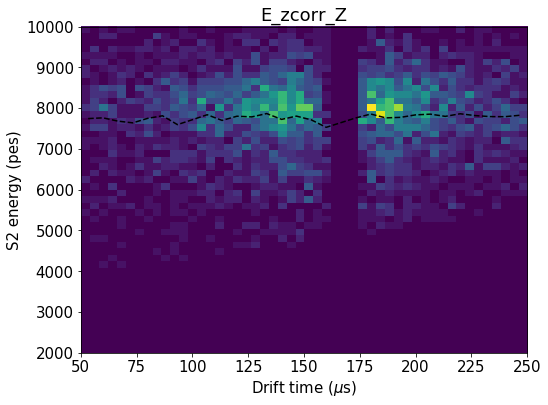

In [18]:
zrange = zrange_
Erange = XRrange_

y, x, _ = \
hist(XRfid.S2e * zcorr(XRfid.Z), 50, range=Erange)
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.polynom(x, *args[3:])
seed = 1e6, 8e3, 6e2, 1
f = fitf.fit(fun, x, y, seed, fit_range=(7300, 9000))
plt.plot(x, f.fn(x), "r-")
print(f.values, f.chi2, reso(f.values[:3], 29.6))
plt.ylim(0)
plt.text(plt.xlim()[0] + 100, plt.ylim()[0] + 100, gausstext(f.values[:3], 29.6))

labels("S2 energy (pes)", "Entries")
save("E_zcorr_fiducial")


y, x, _ = \
hist(XR.S2e * zcorr(XR.Z), 50, range=Erange)
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3])# + fitf.polynom(x, *args[3:])
seed = 1e6, 7e3, 6e2#, 2e3, -0.1
f = fitf.fit(fun, x, y, seed, fit_range=(7300, 9000))
plt.plot(x, f.fn(x), "r-")
print(f.values, f.chi2, reso(f.values[:3], 29.6))
plt.ylim(0)
plt.text(plt.xlim()[0] + 100, plt.ylim()[0] + 100, gausstext(f.values[:3], 29.6))

labels("S2 energy (pes)", "Entries")
save("E_zcorr")

hist2d(XR.Z, XR.S2e * zcorr(XR.Z), (50, 50), range=(zrange, Erange))
x, y, _ = fitf.profileX(XR.Z, XR.S2e* zcorr(XR.Z), 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("E_zcorr_Z")


# Energy vs position

8310.36112553


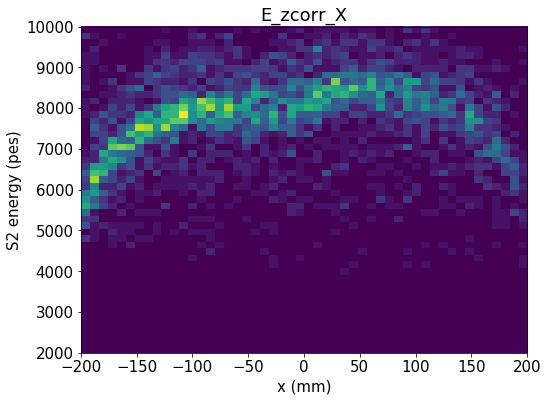

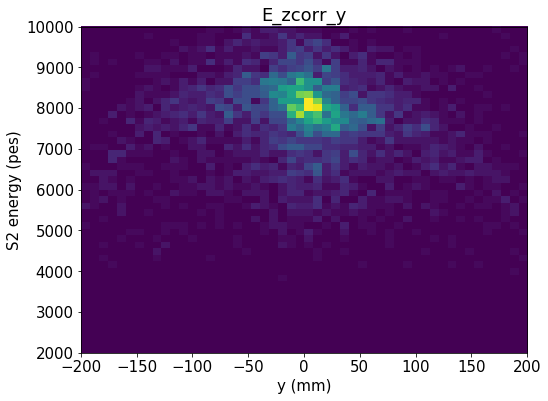

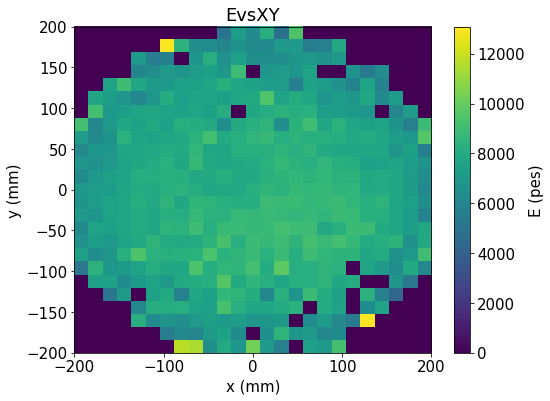

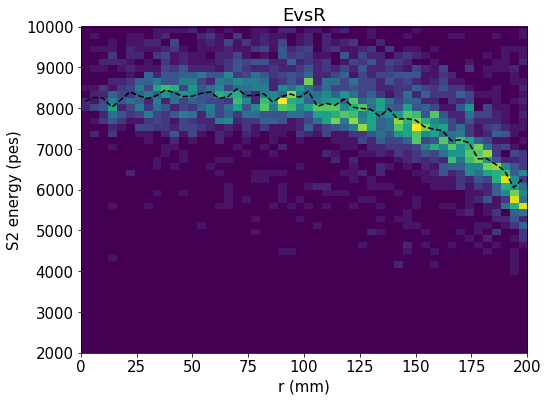

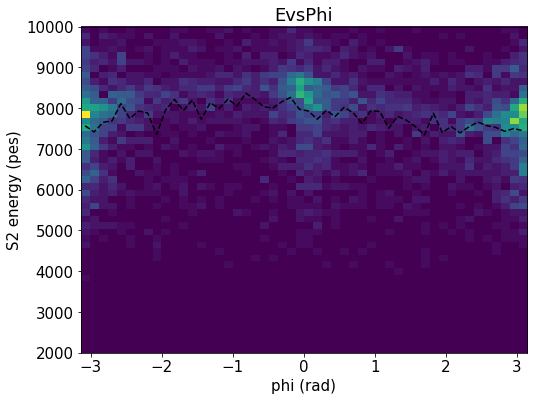

In [33]:
xrange = -200, 200
yrange = -200, 200
rrange =    0, 200
prange = - pi,  pi
Erange =  XRrange_

E = XR.S2e * zcorr(XR.Z)

hist2d(XR.X, E, 50, range=(xrange, Erange))
labels("x (mm)", "S2 energy (pes)")
save("E_zcorr_X")

hist2d(XR.Y, E, 50, range=(yrange, Erange))
labels("y (mm)", "S2 energy (pes)")
save("E_zcorr_y")

pf, _, cb = profile_and_scatter(XR.X, XR.Y, E, (25, 25), xrange, yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

hist2d(XR.R, E, (50, 50), (rrange, Erange))
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(XR.Phi, E, (50, 50), (prange, Erange))
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

xycorr = get_xycorr(*pf[:-1])


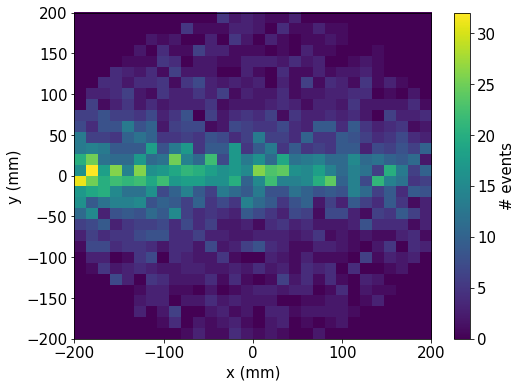

In [34]:
hist2d(XR.X.values, XR.Y.values, 30, ((-200, 200), (-200, 200)))
labels("x (mm)", "y (mm)")
plt.colorbar().set_label("# events")

# Correction by attachment and position

[  2.26372601e+05   8.13691208e+03   3.60606351e+02   4.02422296e+04
   9.18648848e+03   2.57612014e+02   1.22476011e+01] 3.26792410922


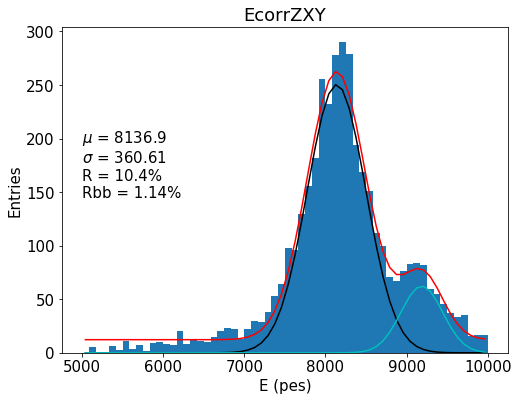

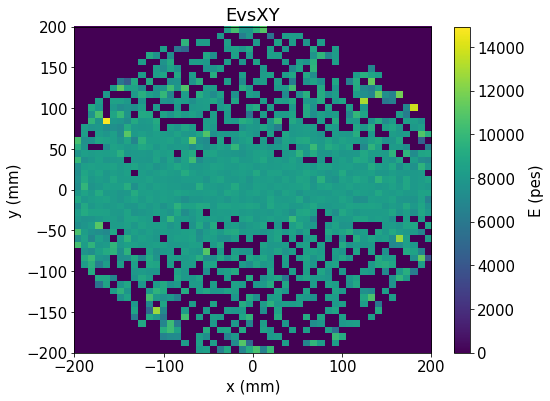

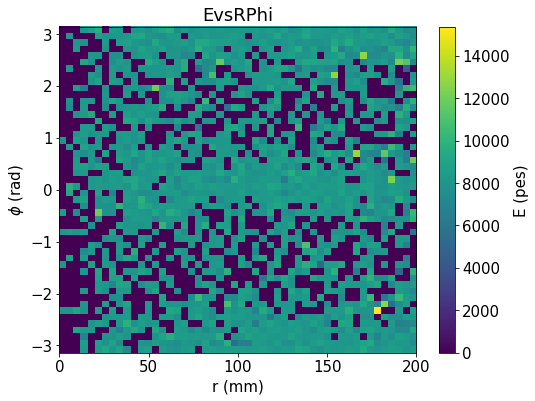

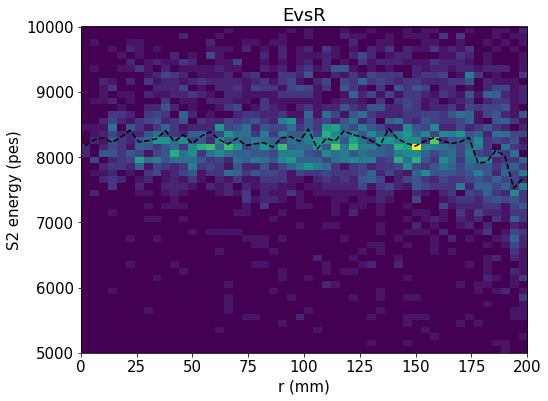

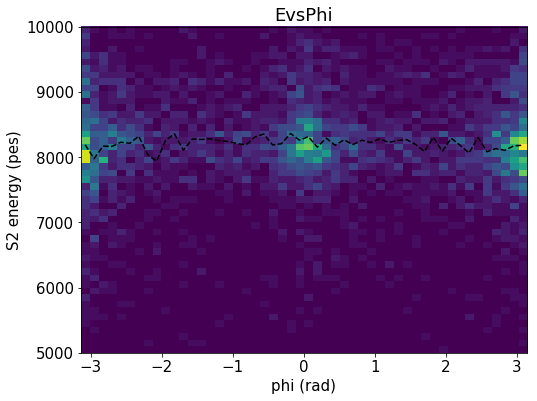

In [49]:
xrange = -200, 200
yrange = -200, 200
rrange =    0, 200
prange = - pi,  pi
Erange =  5e3, 1e4

E  = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values)

y, x, _ = hist(E, 60, Erange)
x    = x[:-1] + np.diff(x) * 0.5

sel  = x != x[np.argmax(y)]
fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + args[-1]
seed = 1e3, 8000, 100, 1e3, 9000, 200,  1
low  =  10, 7900,  50,  10, 8800, 100,  0
upp  = 5e6, 8200, 800, 5e5, 9400, 900, 50
f    = fitf.fit(fun, x[sel], y[sel], seed, fit_range=(5000, 10000), bounds=(low, upp))
print(f.values, f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:6]), XR2Opt)
plt.text(Erange[0], max(y)/2, gausstext(f.values[:3]))
labels("E (pes)", "Entries")
save("EcorrZXY")

_, _, cb = profile_and_scatter(XR.X, XR.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(XR.R, XR.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(XR.R, E, (50, 50), range=(rrange, Erange))
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(XR.Phi, E, (50, 50), range=(prange, Erange))
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")


# Energy vs time

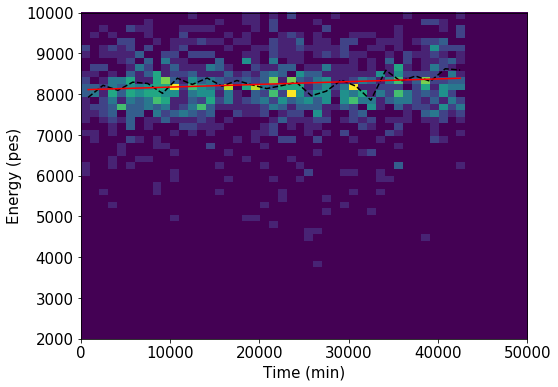

In [50]:
E = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values)
T = (XR.time - np.min(XR.time))

Erange = XRrange
Trange = 0, 50000

hist2d(T, E, (50, 50), range=(Trange, Erange))

x, y, _ = fitf.profileX(T, E, 30, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")

f = fitf.fit(fitf.polynom, x, y, (8e3, 1))
plt.plot(x, f.fn(x), fitOpt)


tfun  = f.fn
tmax  = tfun(Trange[1])
tcorr = lambda t: tmax/tfun(t)

[ 479188.732173      7800.             685.97380577] 1.27939742995


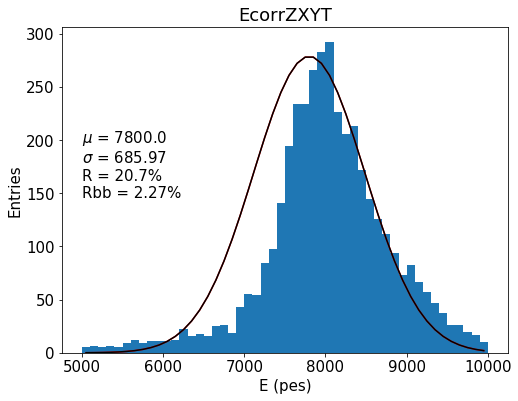

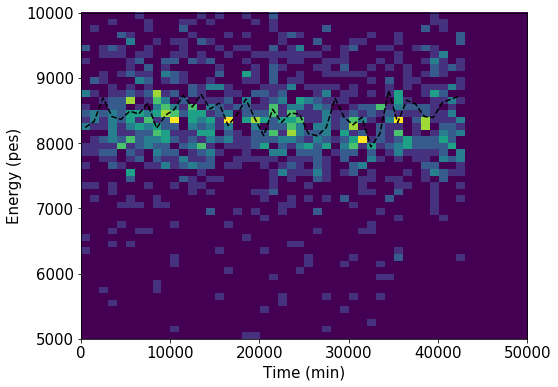

In [52]:
T = (XR.time - np.min(XR.time))
E = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values) * tcorr(T)

Trange = 0, 50000
Erange = 5e3, 1e4

y, x, _ = hist(E, 50, Erange)
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3])# + fitf.gauss(x, *args[3:6]) + args[-1]
seed = 1e3, 8000, 100#, 1e3, 9000, 200,  1
low  =  10, 7800,  50#,  10, 8000, 100,  0
upp  = 5e6, 9000, 800#, 5e5, 9200, 800, 50
f    = fitf.fit(fun, x, y, seed, fit_range=(7800, 9000), bounds=(low, upp))
print(f.values, f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
#plt.plot(x, fitf.gauss(x, *f.values[3:6]), XR2Opt)
plt.text(Erange[0], max(y)/2, gausstext(f.values[:3]))
labels("E (pes)", "Entries")
save("EcorrZXYT")

hist2d(T, E, (50, 50), range=(Trange, Erange))
x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")


[  4.50190898e+06   1.41741122e+05   6.07052925e+03   2.25588463e+02
  -1.37445441e-03] 3.03190247266


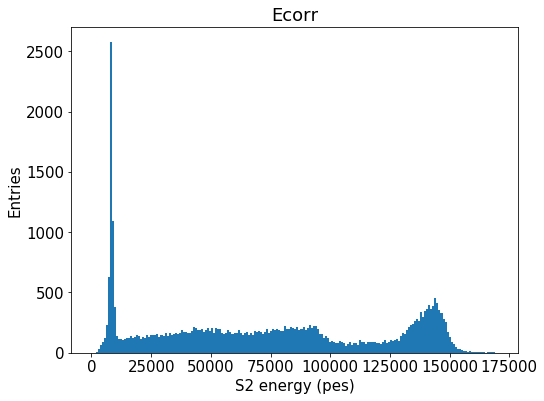

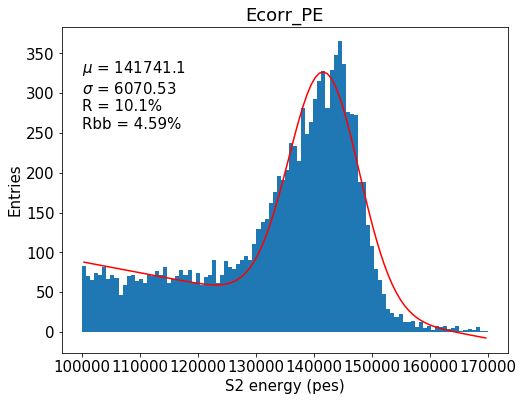

In [59]:
Erange  =   0, 17e4
PErange = 1e5, 17e4
E       = full.S2e * zcorr(full.Z) * xycorr(full.X.values, full.Y.values)

hist(E, 200, Erange)
labels("S2 energy (pes)", "Entries")
save("Ecorr")

y, x, _ = \
hist(E, 100, PErange)
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.polynom(x, *args[3:5])
seed = 1e7, 145e3, 1e3, 1e5, -1e4
f    = fitf.fit(fun, x, y, seed, fit_range=(100e3, 170e3))
print(f.values, f.chi2)
plt.plot(x, f.fn(x), fitOpt)
plt.text(PErange[0], plt.ylim()[1]*2/3, gausstext(f.values[:3], 511))

labels("S2 energy (pes)", "Entries")
save("Ecorr_PE")

In [66]:
PE = full
#PE = PE[coref.in_range(PE.S1e,  100,   150)]
PE = PE[coref.in_range(PE.S2e,  9e4,  13e4)]
PE = PE[coref.in_range(PE.Z  ,  140,   200)]
PE = PE[coref.in_range(PE.Y  ,  -20,    20)]
#PE = PE[coref.in_range(PE.X  , -100,   -10)]
#PE = PE[PE.nS2==1]

#PE = PE[coref.in_range(PE.S2e * zcorr(PE.Z) * xycorr(PE.X.values, PE.Y.values), 110e3, 150e3)]

len(PE)

5601

[  5.24424217e+06   1.44856817e+05   3.61482429e+03   3.40370861e+06
   1.36484547e+05   4.41078466e+03]


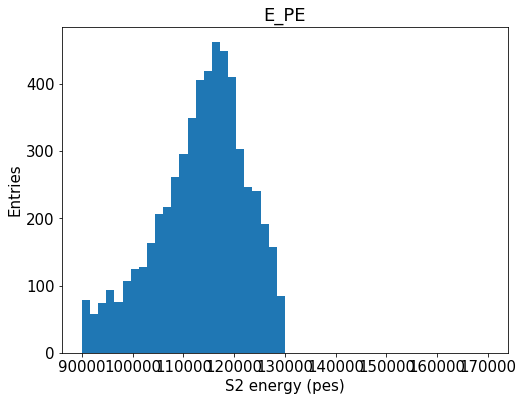

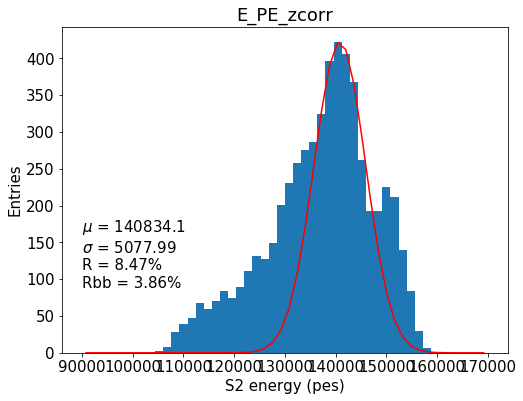

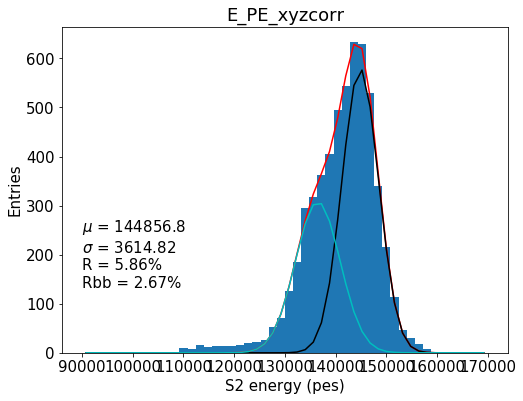

In [77]:
PErange = 9e4, 17e4
Erange  = 9e4, 17e4
E       = np.array(PE.S2e.values)

hist(E, 50, PErange)
labels("S2 energy (pes)", "Entries")
save("E_PE")


E *= zcorr(PE.Z)
y, x, _ = \
hist(E, 50, PErange)
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3])# + fitf.polynom(x, *args[3:])
seed = 1e6, 140e3, 1e3#, 1e3, 1e-2
f    = fitf.fit(fun, x, y, seed, fit_range=(136e3, 145e3))

plt.plot(x, f.fn(x), fitOpt)
plt.text(PErange[0]+100, plt.ylim()[1]/5, gausstext(f.values[:3], 511))
labels("S2 energy (pes)", "Entries")
save("E_PE_zcorr")



E *= xycorr(PE.X.values, PE.Y.values)

y, x, _ = \
hist(E, 50, PErange)
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:])
seed = 1e6, 145e3, 1e3, 1e4, 137e3, 1e3
f    = fitf.fit(fun, x, y, seed, fit_range=(120e3, 160e3))

print(f.values)
plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:]), XR2Opt)

plt.text(PErange[0]+100, plt.ylim()[1]/5, gausstext(f.values[:3], 511))
labels("S2 energy (pes)", "Entries")
save("E_PE_xyzcorr")

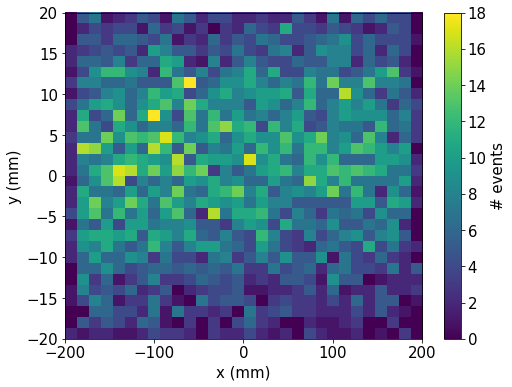

In [78]:
hist2d(PE.X.values, PE.Y.values, 30, ((-200, 200), (-20, 20)))
labels("x (mm)", "y (mm)")
plt.colorbar().set_label("# events")

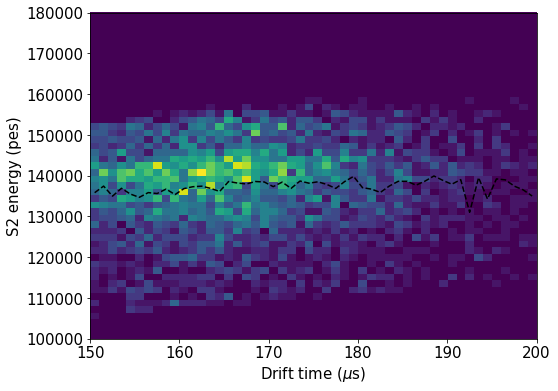

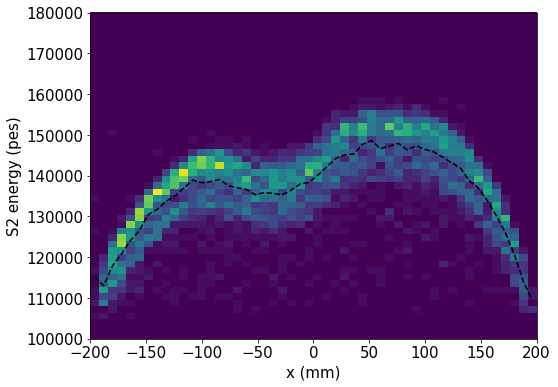

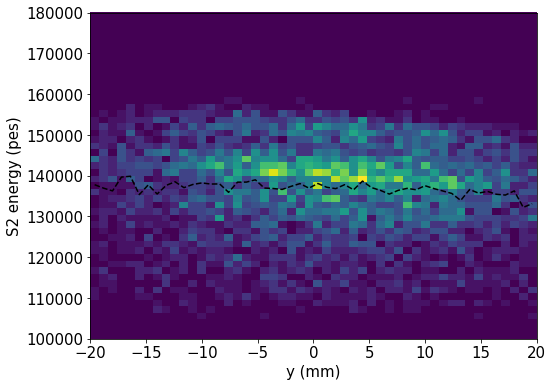

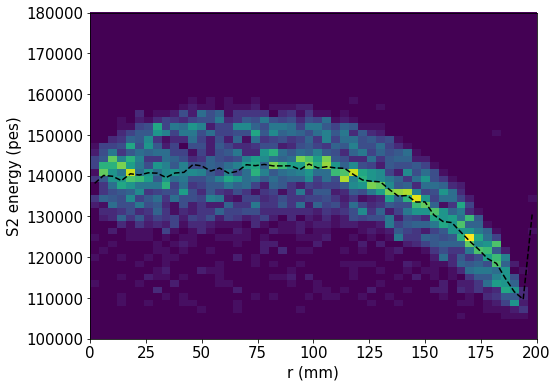

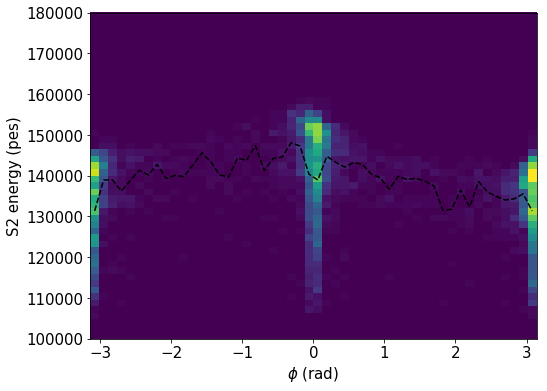

In [79]:
xrange = -200,  200
yrange = - 20,   20
rrange =    0,  200
prange = - pi,   pi
zrange =  150,  200
Erange = 10e4, 18e4
E      = np.array(PE.S2e.values) * zcorr(PE.Z.values)

hist2d(PE.Z, E, 50, (zrange, Erange))
x, y, _ = fitf.profileX(PE.Z.values, E, 50, zrange)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 energy (pes)")

hist2d(PE.X, E, 50, (xrange, Erange))
x, y, _ = fitf.profileX(PE.X.values, E, 50, xrange)
plt.plot(x, y, profOpt)
labels("x (mm)", "S2 energy (pes)")

hist2d(PE.Y, E, 50, (yrange, Erange))
x, y, _ = fitf.profileX(PE.Y.values, E, 50, yrange)
plt.plot(x, y, profOpt)
labels("y (mm)", "S2 energy (pes)")

hist2d(PE.R, E, 50, (rrange, Erange))
x, y, _ = fitf.profileX(PE.R.values, E, 50, rrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")

hist2d(PE.Phi, E, 50, (prange, Erange))
x, y, _ = fitf.profileX(PE.Phi.values, E, 50, prange)
plt.plot(x, y, profOpt)
labels("$\phi$ (rad)", "S2 energy (pes)")

In [80]:
_x     = np.array([ -200,  -150,  -100,   -50,     0,    50,   100,   125,   160,   200])
_emin  = np.array([100e3, 120e3, 137e3, 133e3, 135e3, 142e3, 140e3, 135e3, 122e3, 100e3])
_emax  = np.array([122e3, 137e3, 147e3, 145e3, 147e3, 157e3, 155e3, 152e3, 142e3, 122e3])

_eminfid = scp.interpolate.interp1d(_x, _emin, fill_value="extrapolate")
_emaxfid = scp.interpolate.interp1d(_x, _emax, fill_value="extrapolate")

PEfid = PE[coref.in_range(np.array(PE.S2e.values) * zcorr(PE.Z.values), _eminfid(PE.X), _emaxfid(PE.X))]

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


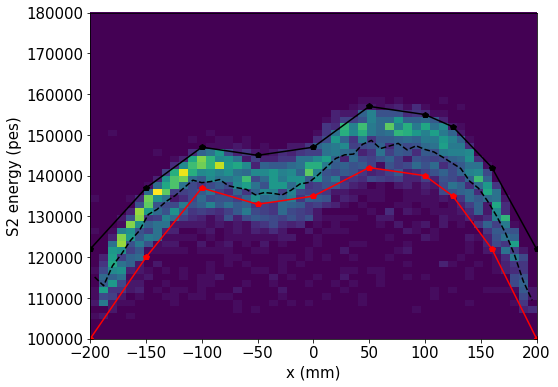

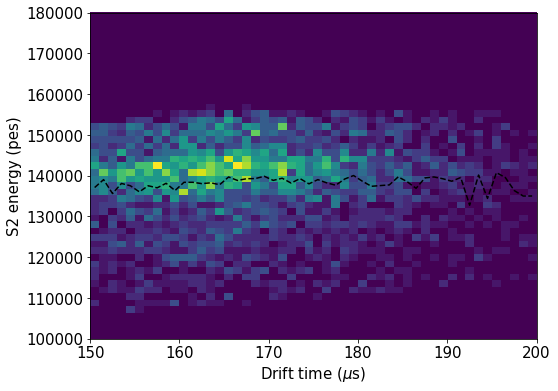

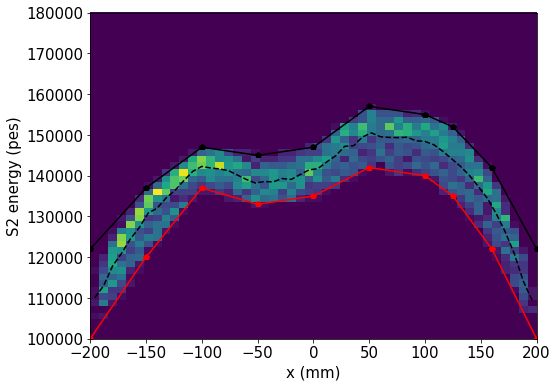

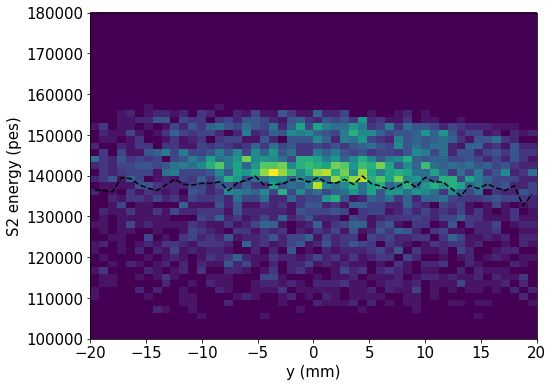

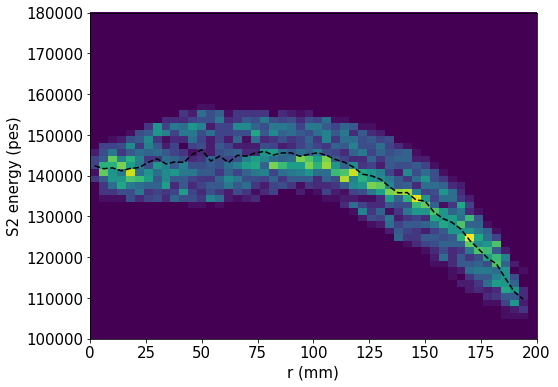

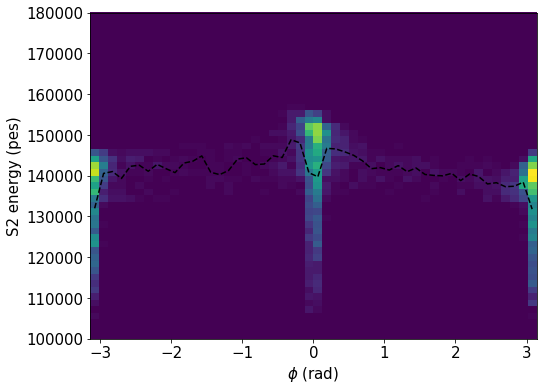

In [81]:
xrange = -200,  200
yrange = - 20,   20
rrange =    0,  200
prange = - pi,   pi
zrange =  150,  200
Erange = 10e4, 18e4
E      = np.array(PE.S2e.values) * zcorr(PE.Z.values)

hist2d(PE.X, E, 50, (xrange, Erange))
x, y, _ = fitf.profileX(PE.X.values, E, 50, xrange)
plt.plot(x, y, profOpt)
plt.plot(_x, _emin, "pr-", _x, _emax, "pk-")
labels("x (mm)", "S2 energy (pes)")

E     = np.array(PEfid.S2e.values) * zcorr(PEfid.Z.values)

hist2d(PEfid.Z, E, 50, (zrange, Erange))
x, y, _ = fitf.profileX(PEfid.Z.values, E, 50, zrange)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 energy (pes)")

hist2d(PEfid.X, E, 50, (xrange, Erange))
x, y, _ = fitf.profileX(PEfid.X.values, E, 50, xrange)
plt.plot(x, y, profOpt)
plt.plot(_x, _emin, "pr-", _x, _emax, "pk-")
labels("x (mm)", "S2 energy (pes)")

hist2d(PEfid.Y, E, 50, (yrange, Erange))
x, y, _ = fitf.profileX(PEfid.Y.values, E, 50, yrange)
plt.plot(x, y, profOpt)
labels("y (mm)", "S2 energy (pes)")

hist2d(PEfid.R, E, 50, (rrange, Erange))
x, y, _ = fitf.profileX(PEfid.R.values, E, 50, rrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")

hist2d(PEfid.Phi, E, 50, (prange, Erange))
x, y, _ = fitf.profileX(PEfid.Phi.values, E, 50, prange)
plt.plot(x, y, profOpt)
labels("$\phi$ (rad)", "S2 energy (pes)")

125000.0


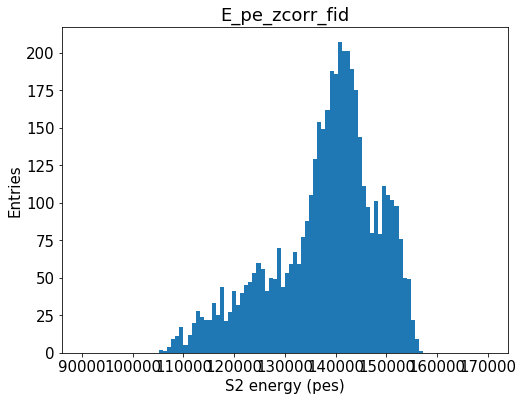

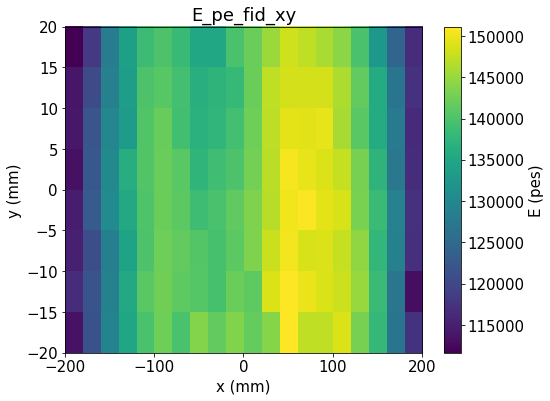

In [82]:
Erange = PErange
E = PEfid.S2e * zcorr(PEfid.Z)

hist(E, 100, Erange)
labels("S2 energy (pes)", "Entries")
save("E_pe_zcorr_fid")

pf, _, cb = profile_and_scatter(PEfid.X, PEfid.Y, E, (20, 8), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("E_pe_fid_xy")
xycorrPE = get_xycorr(*pf[:-1], 125e3)

[ 1368020.33690712   126441.81305538     2338.44344881   467256.66175018
   120628.89781868     2408.78243169] 2.25021877249


/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


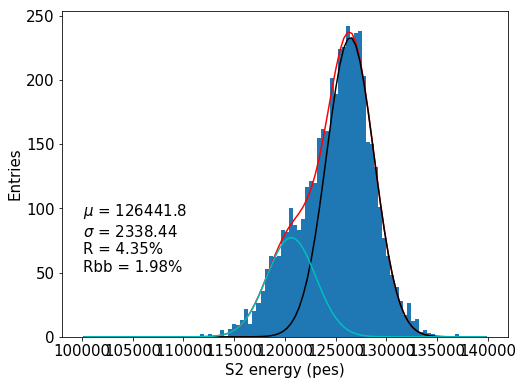

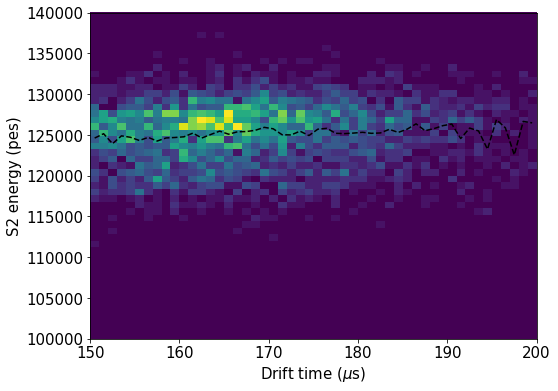

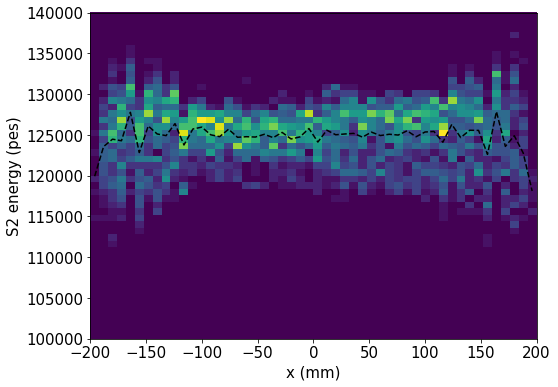

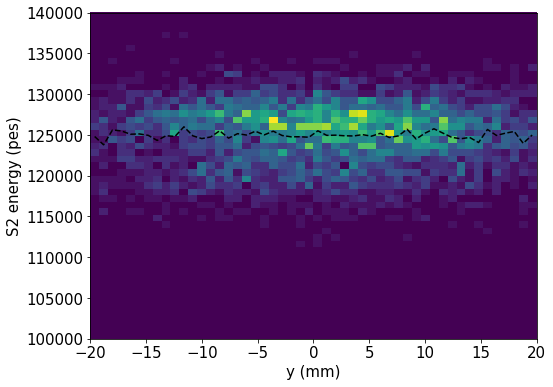

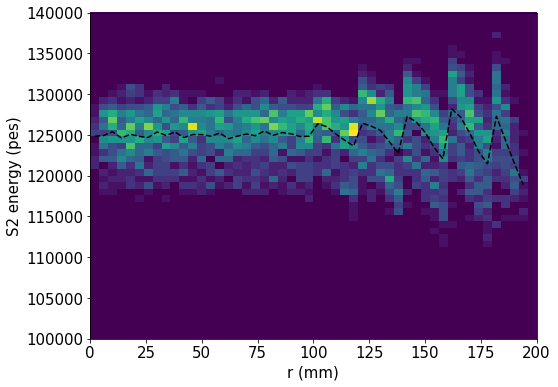

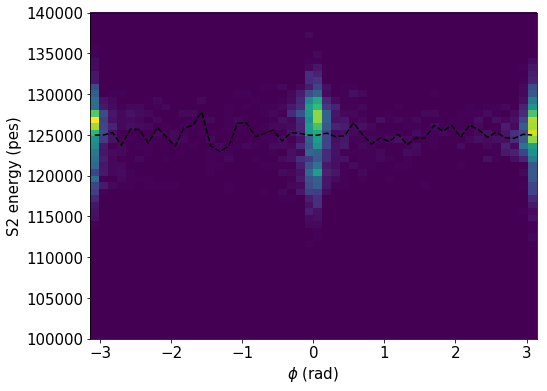

In [87]:
xrange = -200,  200
yrange = - 20,   20
rrange =    0,  200
prange = - pi,   pi
zrange =  150,  200
Erange = 10e4, 14e4
E      = np.array(PEfid.S2e.values) * zcorr(PEfid.Z.values) * xycorrPE(PEfid.X.values, PEfid.Y.values)

y, x, _ = \
hist(E, 100, Erange)
x = x[:-1] + np.diff(x) * 0.5
labels("S2 energy (pes)", "Entries")

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:])
seed = 1e7, 127e3, 2e3, 1e4, 120e3, 1e3
low  = 1e5, 125e3, 1e3, 1e2, 115e3, 1e3
upp  = 1e9, 133e3, 1e4, 1e8, 125e3, 1e4
f    = fitf.fit(fun, x, y, seed, bounds=(low, upp), fit_range=(115e3, 135e3))
plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:]), XR2Opt)
plt.text(Erange[0]+100, plt.ylim()[1]/5, gausstext(f.values[:3], 511))
print(f.values, f.chi2)

hist2d(PEfid.Z, E, 50, (zrange, Erange))
x, y, _ = fitf.profileX(PEfid.Z.values, E, 50, zrange)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 energy (pes)")

hist2d(PEfid.X, E, 50, (xrange, Erange))
x, y, _ = fitf.profileX(PEfid.X.values, E, 50, xrange)
plt.plot(x, y, profOpt)
labels("x (mm)", "S2 energy (pes)")

hist2d(PEfid.Y, E, 50, (yrange, Erange))
x, y, _ = fitf.profileX(PEfid.Y.values, E, 50, yrange)
plt.plot(x, y, profOpt)
labels("y (mm)", "S2 energy (pes)")

hist2d(PEfid.R, E, 50, (rrange, Erange))
x, y, _ = fitf.profileX(PEfid.R.values, E, 50, rrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")

hist2d(PEfid.Phi, E, 50, (prange, Erange))
x, y, _ = fitf.profileX(PEfid.Phi.values, E, 50, prange)
plt.plot(x, y, profOpt)
labels("$\phi$ (rad)", "S2 energy (pes)")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


127775.772402


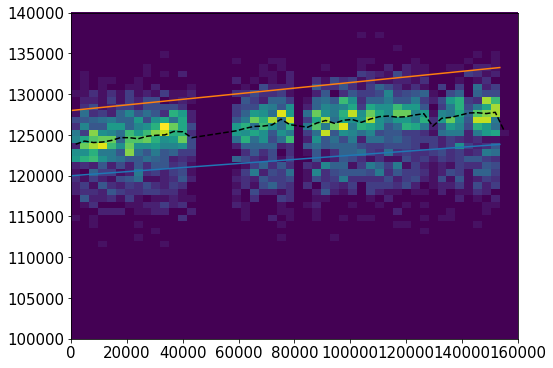

In [92]:
trange = 0, 160e3
Erange = 100e3, 140e3

t0 = np.min(PEfid.time.values)
T  = PEfid.time.values - t0
E  = PEfid.S2e.values * zcorr(PEfid.Z.values) * xycorrPE(PEfid.X.values, PEfid.Y.values)

lowE = 120e3 + 4/160*T
uppE = 128e3 + 6/175*T
sel  = coref.in_range(E, lowE, uppE)


hist2d(T, E, 50, range=(trange, Erange))
plt.plot(T, lowE,
         T, uppE)
x, y, _ = fitf.profileX(T[sel], E[sel], 50, trange)
plt.plot(x, y, profOpt)

tcorr = get_tcorr(x, y, t0)

[ 1435279.3877785    127857.15549787     2078.93530591   371391.49372359
   121417.4119247      1819.57638385] 6.22992290295


/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


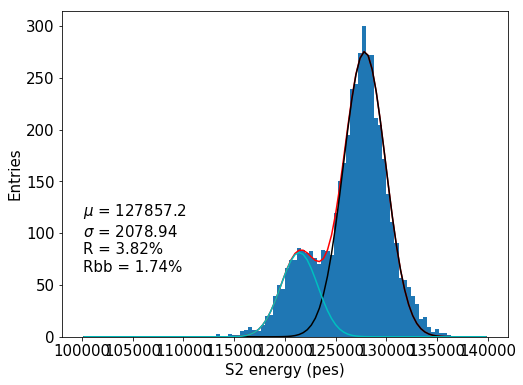

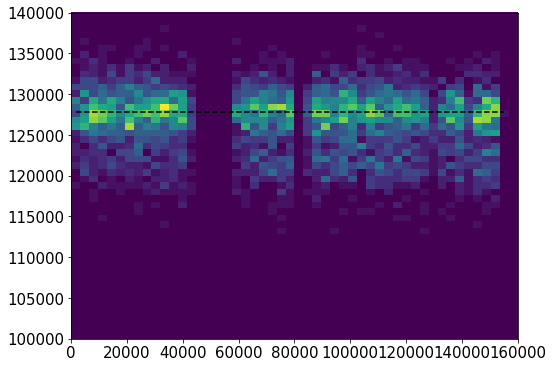

In [94]:
trange = 0, 160e3
Erange = 100e3, 140e3
T      = PEfid.time.values - np.min(PEfid.time.values)
E      = PEfid.S2e.values * zcorr(PEfid.Z.values) * xycorrPE(PEfid.X.values, PEfid.Y.values) * tcorr(PEfid.time.values)

y, x, _ = \
hist(E, 100, Erange)
x = x[:-1] + np.diff(x) * 0.5
labels("S2 energy (pes)", "Entries")

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:])
seed = 1e7, 127e3, 2e3, 1e4, 121e3, 1e3
low  = 1e5, 125e3, 1e3, 1e2, 120e3, 1e2
upp  = 1e9, 130e3, 1e4, 1e8, 125e3, 1e4
f    = fitf.fit(fun, x, y, seed, bounds=(low, upp), fit_range=(115e3, 135e3))
plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:]), XR2Opt)
plt.text(Erange[0]+100, plt.ylim()[1]/5, gausstext(f.values[:3], 511))
print(f.values, f.chi2)

hist2d(T, E, 50, range=(trange, Erange))
x, y, _ = fitf.profileX(T[sel], E[sel], 50, trange)
plt.plot(x, y, profOpt)


[ 720562.18101725  129722.50851622   10000.        ] 3.51964397164
[ 234721.71330731  128262.9706573     1790.80955554] 1.53492440635
[ 278001.95726401  127498.08480116    1430.16373657] 0.967639827015
[ 242797.90408976  126818.44829726    1382.38904981] 3.6803735005
[ 249014.13105029  127204.26920743    1900.09631124] 2.30791291009
[ 214879.49361981  128257.62048897    1516.73732282] 4.48871757827
[ 281143.97296171  128462.56925293    1942.11678344] 0.740286855833
[ 416095.42102898  130283.95823915    3158.98623567] 1.46644028766
[ 461989.34448329  122000.            9405.19474887] 1.04604455129


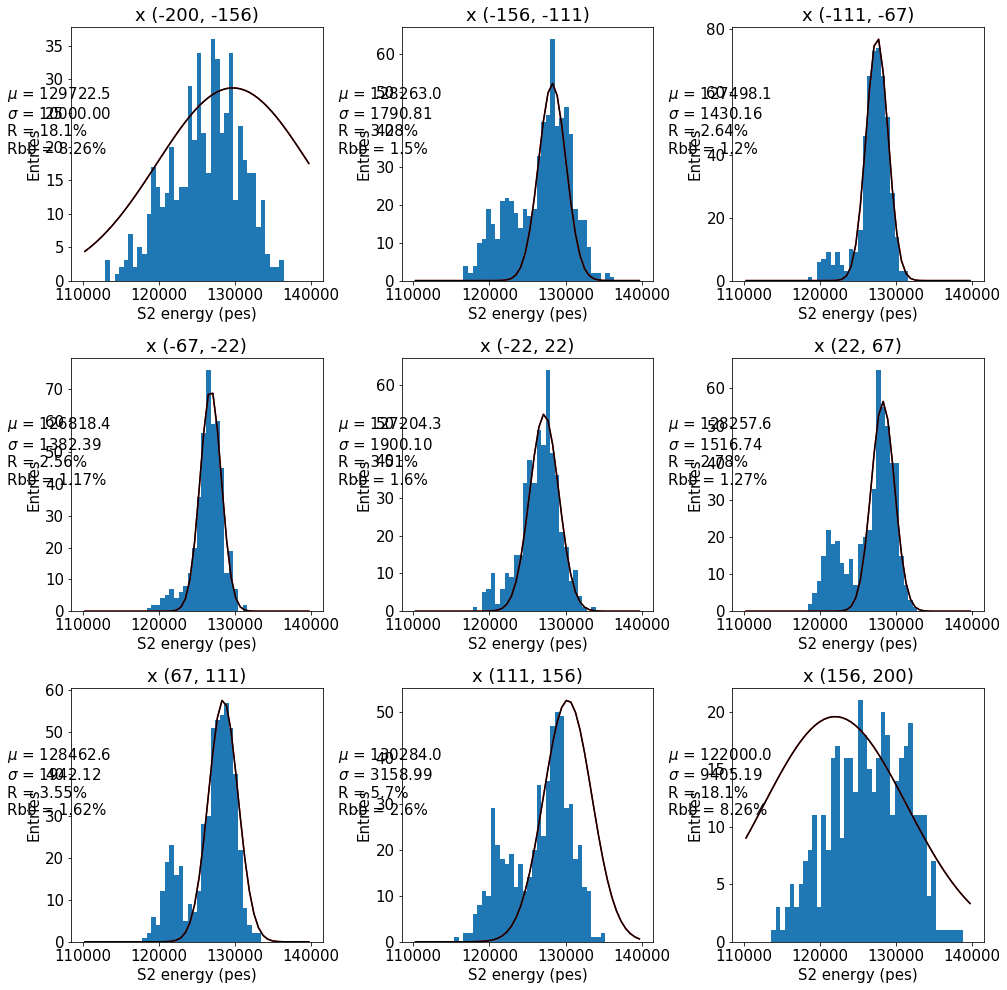

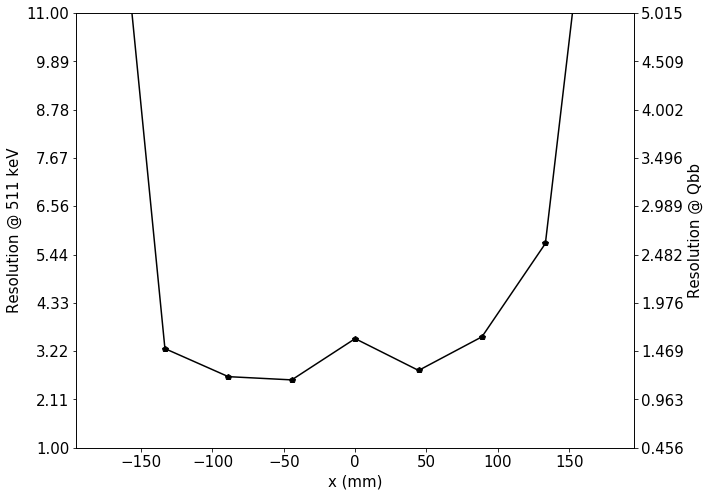

In [95]:
xlim = np.linspace(-200, 200, 10, endpoint=True)

E = PEfid.S2e.values * zcorr(PEfid.Z.values) * xycorrPE(PEfid.X.values, PEfid.Y.values) * tcorr(PEfid.time.values)

R   = []
Rbb = []
plt.figure().set_size_inches(14, 14)
for i in range(9):
    EX = E[coref.in_range(PEfid.X.values, xlim[i], xlim[i+1])]

    plt.subplot(3, 3, i+1)
    y, x, _ = \
    plt.hist(EX, 50, (110e3, 140e3))
    x = x[:-1] + np.diff(x) * 0.5
    labels("S2 energy (pes)", "Entries")

    fun  = lambda x, *args: fitf.gauss(x, *args[:3])# + fitf.gauss(x, *args[3:])
    seed = 1e7, 127e3, 2e3#, 1e6, 123e3, 2e3
    low  = 1e2, 122e3, 1e3#, 1e4, 115e3, 1e3
    upp  = 1e9, 133e3, 1e4#, 1e9, 125e3, 5e3
    f    = fitf.fit(fun, x, y, seed, bounds=(low, upp), fit_range=(125e3, 130e3))
    plt.plot(x, f.fn(x), fitOpt)
    plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
#    plt.plot(x, fitf.gauss(x, *f.values[3:]), XR2Opt)
    plt.text(Erange[0]+100, plt.ylim()[1]/2, gausstext(f.values[:3], 511))
    plt.title("x ({:.0f}, {:.0f})".format(xlim[i], xlim[i+1]))
    print(f.values, f.chi2)

    res, resbb = reso(f.values[:3], 511)
    R  .append(res)
    Rbb.append(resbb)
plt.tight_layout()

xlim = xlim[:-1] + np.diff(xlim) * 0.5
plt.figure(figsize=(10,8))
plt.plot(xlim, R  , "pk-")
plt.ylim(1, 11)
plt.yticks(np.linspace(1, 11, 10))
labels("x (mm)", "Resolution @ 511 keV")

ax2 = plt.gca().twinx()
#ax2.plot(xlim, R, "pk-")
ax2.set_ylim(1 * (511/2458)**0.5, 11 * (511/2458)**0.5)
ax2.set_yticks(np.linspace(1, 11, 10) * (511/2458)**0.5)
ax2.set_ylabel("Resolution @ Qbb");